# **TITLE (TBD)**

This tutorial shows how to access the data related to DANDI:00TBD using pynwb.

This dataset contains sessions with EEG and LFP recordings, accelerometer signals, behavioural paradigm triggers (TTL pulses), behavioral videos.

Contents:

- [Streaming an NWBFile](#stream-nwb)
- [Reading NWBFile locally](#read-nwb)
- [Access EEG Signal](#access-eeg)
- [Access LFP Signal](#access-lfp)
- [Access Behavioral Videos](#access-behavior) 
- [Access Accelerometer Signal](#access-accelerometer)
- [Access Behavioural Paradigm Triggers](#access-ttls)

A schematic representation of ... :   

![Alt text](./arc-ephys-kind-dataset-structure.png)  

---

# Select the subject and session to load

In [1]:
dandi_id = ""
subject_id = "Rat_1021"
session_id = "Baseline_tone_flash_hab"

# Streaming an NWB file <a id="stream-nwb"></a>

This section demonstrates how to access the files on the [DANDI Archive](https://dandiarchive.org) without downloading them. Based on the [Streaming NWB files](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

An [NWBFile](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile) represents a single session of an experiment. Each NWBFile must have a `session description`, `identifier`, and `session start time`.

The `dandi.dandiapi.DandiAPIClient` can be used to get the S3 URL of the NWB file stored in the DANDI Archive.

```python
from dandi.dandiapi import DandiAPIClient

nwbfile_path = f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}.nwb"

dandiset_id = ""
with DandiAPIClient() as client:
    #This line is necessary when the dataset is in embargoed mode and only owners can view the data, once it will be published this line can be removed.
    client.dandi_authenticate() 
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(nwbfile_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)

import h5py
import remfile
from pynwb import NWBHDF5IO

file = remfile.File(s3_url)
h5_file = h5py.File(file, "r")
io = NWBHDF5IO(file=h5_file, load_namespaces=True)
```

# Reading an NWB file locally<a id="read-nwb"></a>


This section demonstrates how to read an NWB file using `pynwb`.

Based on the [NWB File Basics](https://pynwb.readthedocs.io/en/stable/tutorials/general/plot_file.html#sphx-glr-tutorials-general-plot-file-py) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

An [NWBFile](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile) represents a single session of an experiment. Each NWBFile must have a `session description`, `identifier`, and `session start time`.

Reading is carried out using the [NWBHDF5IO](https://pynwb.readthedocs.io/en/stable/pynwb.html#pynwb.NWBHDF5IO) class. To read the NWB file use the read mode ("r") to retrieve an NWBFile object.


In [2]:
from pynwb import NWBHDF5IO

# adapt the path
nwbfile_path = f"D:/kind_lab_conversion_nwb/sub_{subject_id}-ses_{session_id}.nwb"
io = NWBHDF5IO(path=nwbfile_path, load_namespaces=True)
nwbfile = io.read()

In [3]:
nwbfile.experiment_description

'The experiment investigated fear conditioning in male wild-type and Syngap+/âˆ†-GAP rats (n=31, ages 3-6 months). Recordings included Local Field Potentials (LFP), electroencephalogram (EEG), head-mounted accelerometer data, and behavioral video recordings across five experimental days. The protocol involved context habituation, seizure screening, and a fear conditioning paradigm where rats were exposed to blue flashing light (5 Hz, 110 lux) paired with foot shocks. Data were collected using OpenEphys software and a 16-channel Intan digitizing head stage. Behavioral paradigm triggers were managed using FreezeFrame software, and behavioral cameras recorded rat movements throughout the experimental sessions. The experimental design allowed for assessing neural responses, seizure occurrence, and fear learning in these genetic variants.'

In [4]:
nwbfile.session_description

'Experimental day 4. Session to probe CS (blue led flash) pre-exposure without fear. On experimental day 4, recordings were made while a subset of 19 rats were pre-exposed to 10s of blue flashing light (5 Hz 110 lux flashes, 50 / 50 duty cycle) of the same properties as that used for subsequent conditioning and recall, the purpose of this exposure was to test for behavioral and LFP responses to the sensory stimuli prior to association with a footshock. Pre-exposure was followed immediately by conditioning.'

Importantly, the `session start time` is the reference time for all timestamps in the file. For instance, an event with a timestamp of 0 in the file means the event occurred exactly at the session start time.

The `session_start_time` is extracted from all_sessions.Session datajoint table.

In [5]:
nwbfile.session_start_time

datetime.datetime(2020, 9, 24, 14, 7, 1, tzinfo=tzoffset(None, 3600))

# Access subject <a name="access-subject"></a>

This section demonstrates how to access the [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field in an NWB file.

The [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field can be accessed as `nwbfile.subject`.


In [6]:
nwbfile.subject

subject pynwb.file.Subject at 0x2365738557488
Fields:
  age: P12W/P24W
  age__reference: birth
  description: Subjects were Evans-SGem2/PWC were genotyped by PCR. This study used male rats (n=31, 16 wild-types and 15 Syngap+/âˆ†-GAP) bred in-house and maintained in standard housing on a 12h/12h light dark with ad libitum access to water and food. Experimental animals were weaned from their dams postnatal day 22 (P22D) and housed with their WT littermates, 2-4 animals per cage. Genetically modified males and WT littermates ranging from 3 to 6 months of age were used for all experiments.
  genotype: WT
  sex: M
  species: Rattus norvegicus
  subject_id: Rat_1021

# Access EEG Signal <a id="access-eeg"></a>

This section demonstrates how to access the EEG data.

`NWB` organizes data into different groups depending on the type of data. Groups can be thought of as folders within the file. Here are some of the groups within an NWBFile and the types of data they are intended to store:

- `acquisition`: raw, acquired data that should never change
- `processing`: processed data, typically the results of preprocessing algorithms and could change

## Raw EEG signals 

The raw EEG data is stored in [pynwb.ecephys.ElectricalSeries](https://pynwb.readthedocs.io/en/stable/pynwb.ecephys.html#pynwb.ecephys.ElectricalSeries) object, which are added to `nwbfile.acquisition`.

The data in ElectricalSeries is stored as a two-dimensional array:

The first dimension corresponds to time (individual samples).
The second dimension corresponds to recorded channels.
Each row in the array represents a single time point, and each column corresponds to the signal recorded from a specific channel.



In [7]:
eeg_series = nwbfile.acquisition["eeg_series"]
eeg_series

eeg_series pynwb.ecephys.ElectricalSeries at 0x2365738132464
Fields:
  comments: no comments
  conversion: 1.9499999999999999e-07
  data: <HDF5 dataset "data": shape (727040, 3), type "<i2">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  offset: 0.0
  rate: 2000.0
  resolution: -1.0
  starting_time: 838.912
  starting_time_unit: seconds
  unit: volts

The electrodes that generated this electrical series are stored referenced in a dynamic table region: `pynwb.ecephys.ElectricalSeries.electrodes`

In [8]:
eeg_series.electrodes.to_dataframe()


,location,group,group_name,channel_name,probe_shank,probe_electrode,bad_channel,ref_elect_id
id,,,,,,,,
9,OB,OB_EEG_electrode_group abc.NwbElectrodeGroup a...,OB_EEG_electrode_group,CH10,9,9,False,9
10,M1,M1_EEG_electrode_group abc.NwbElectrodeGroup a...,M1_EEG_electrode_group,CH11,10,10,False,10
11,HPC,HPC_EEG_electrode_group abc.NwbElectrodeGroup ...,HPC_EEG_electrode_group,CH12,11,11,False,11


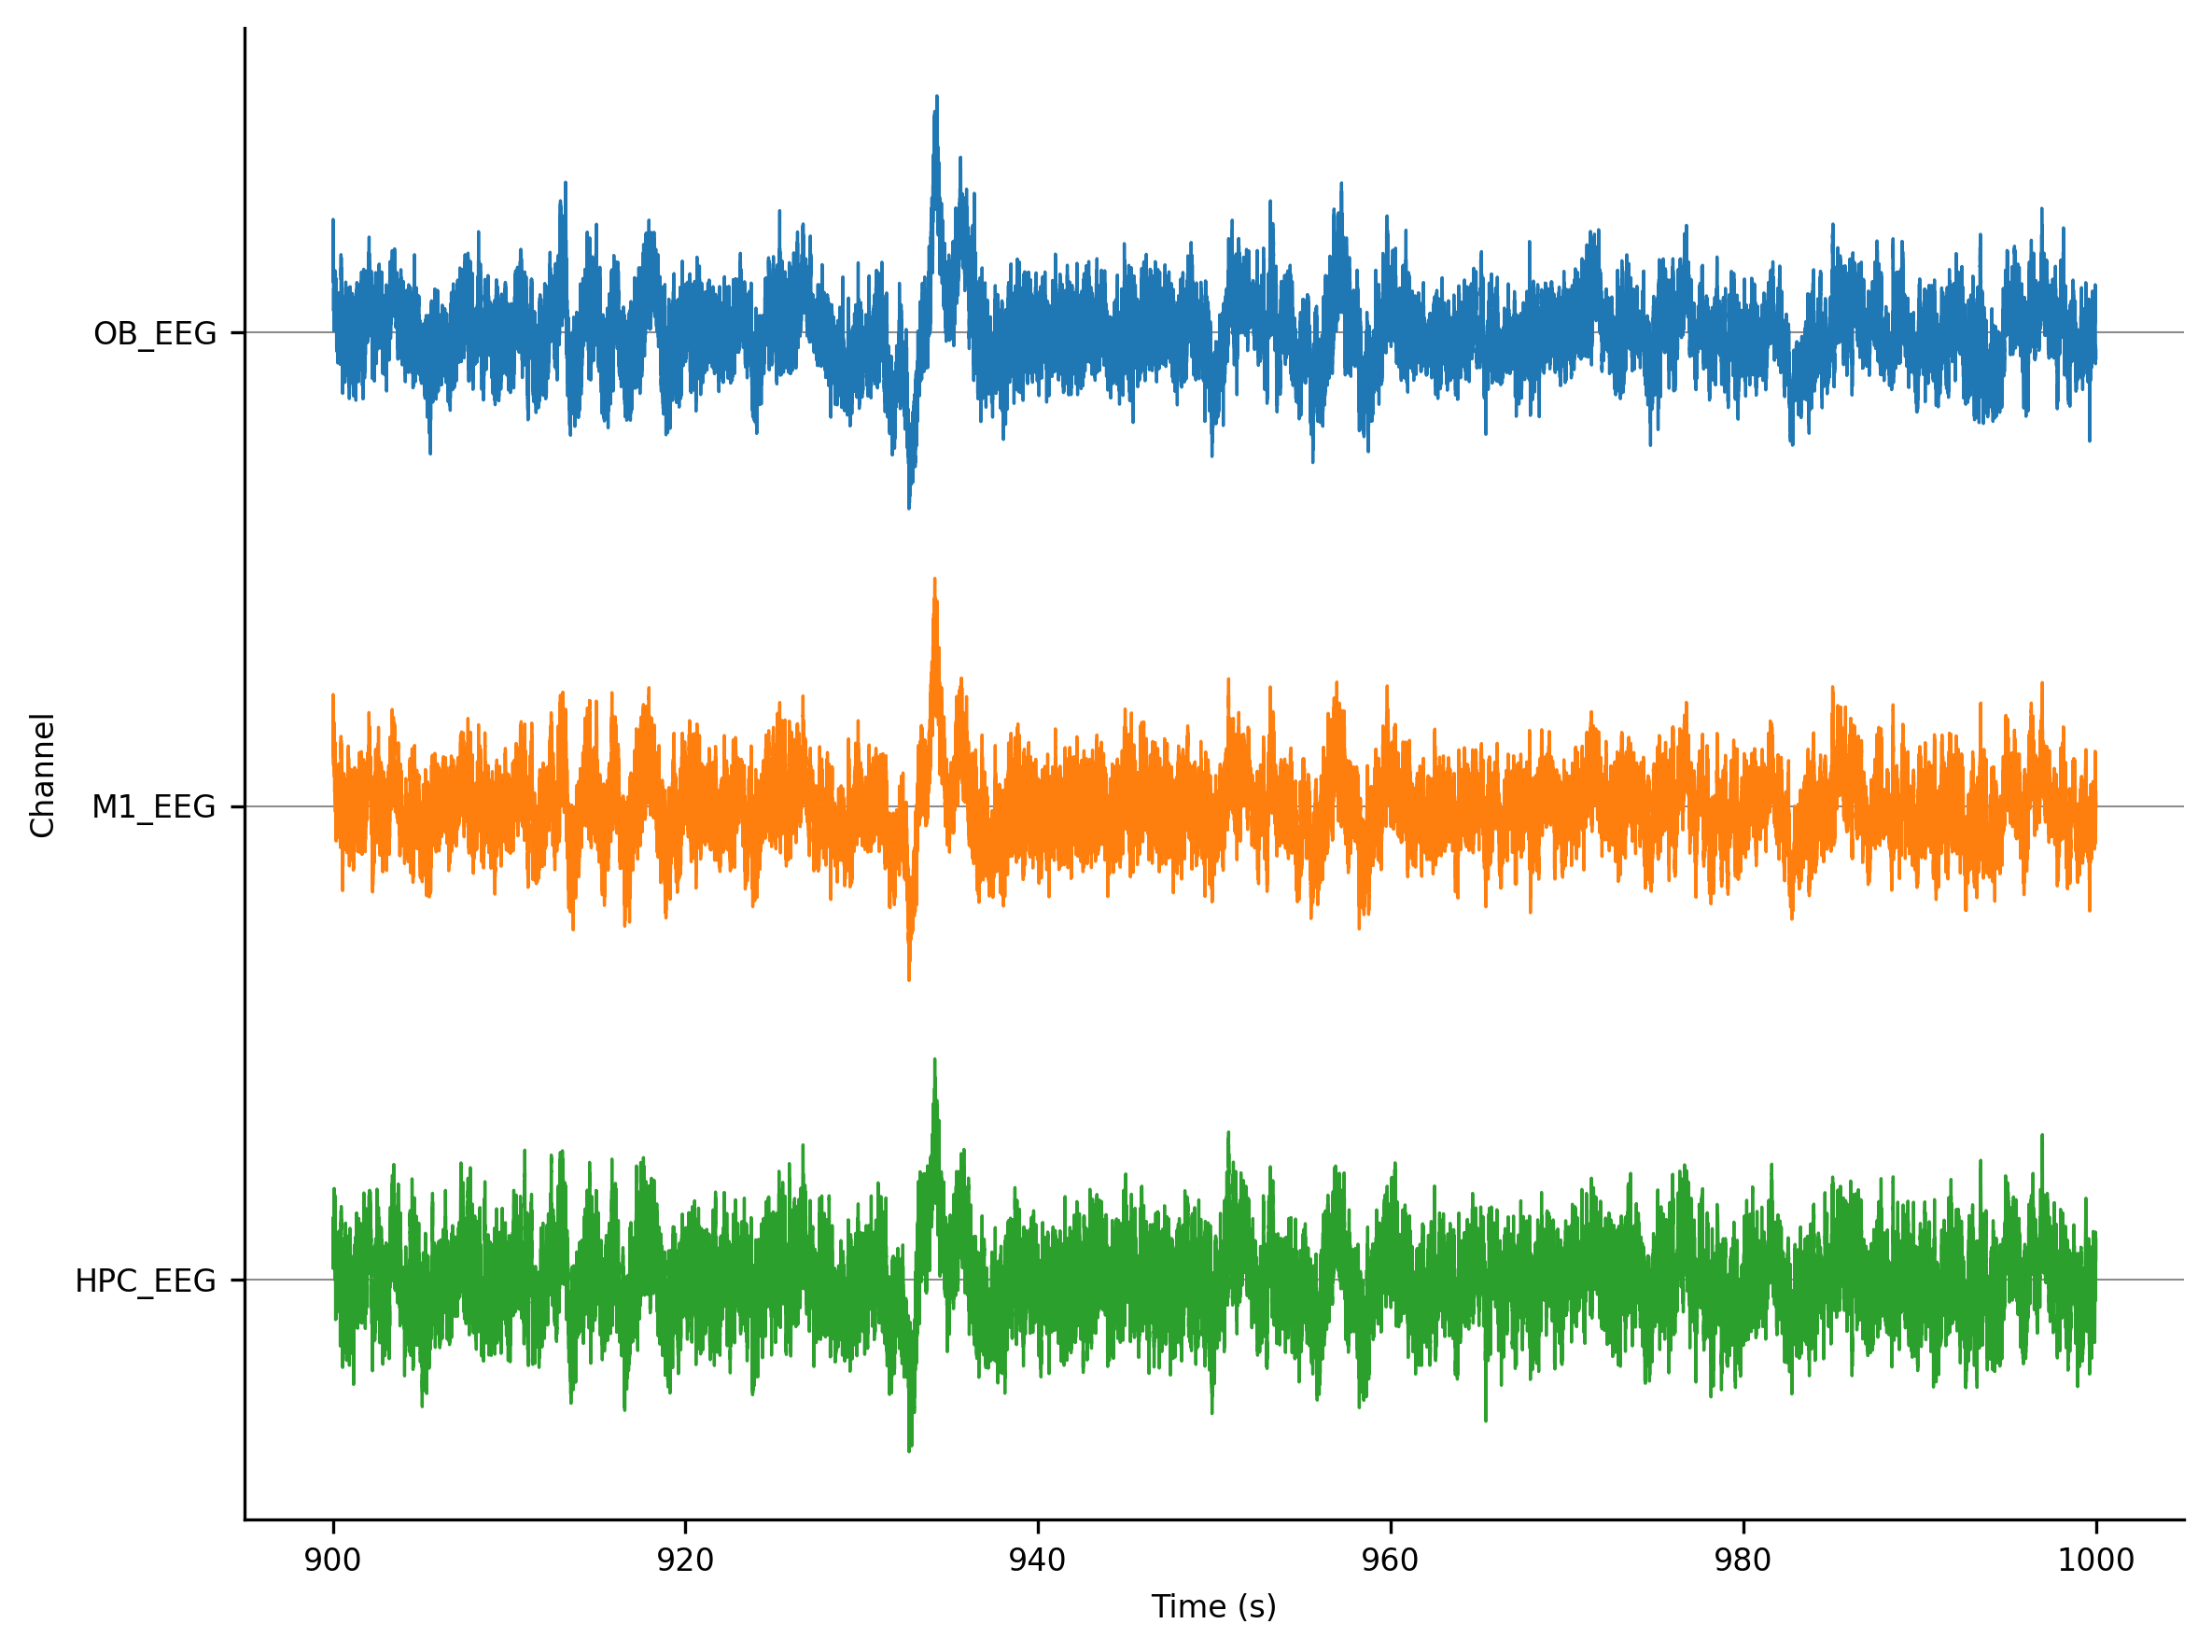

In [14]:
import numpy as np
from matplotlib import pyplot as plt

# Define your window (start and end indices)
start_time = 900  # seconds
end_time = 1000.0  # seconds
timestamps = eeg_series.get_timestamps()
start_idx = np.where(timestamps >= start_time)[0][0] if len(np.where(timestamps >= start_time)[0]) > 0 else 0
end_idx = (np.where(timestamps <= end_time)[0][-1] if len(np.where(timestamps <= end_time)[0]) > 0 else len(timestamps) - 1)

# Get the data and timestamps properly
data = np.array(eeg_series.data[start_idx:end_idx])
timestamps = timestamps[start_idx:end_idx]

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Calculate offset for stacking
offset = np.max(np.abs(data)) * 2
y_positions = []

# Plot zero lines for each channel
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.9, linewidth=0.5)
    y_positions.append(y_offset)

# Plot the LFP signals with offset
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.plot(timestamps, data[:, i] + y_offset, linewidth=0.8)

# # Add scale bar
# scale_x = timestamps[0] + (timestamps[-1] - timestamps[0]) * 0.05  # 5% from left
# scale_y = max(y_positions) + offset/2
# ax.plot([scale_x, scale_x], [scale_y, scale_y + 1000], 'k-', linewidth=2)
# ax.text(scale_x + 0.01, scale_y + 500, '1000 µV', rotation=90, va='center')

# Style the plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.tick_params(axis="both", labelsize=8)
ax.set_yticks(y_positions)
yticklabels = eeg_series.electrodes.to_dataframe()["group_name"]
yticklabels = yticklabels.str.replace("_electrode_group", "")
ax.set_yticklabels(yticklabels, fontsize=8)

plt.xlabel("Time (s)", fontsize=8)
plt.ylabel("Channel", fontsize=8)

plt.tight_layout()
plt.show()

# Access LFP Signal <a name="access-lfp"></a>

This section demonstrates how to access the LFP signals recorded during the experiment.

LFP data are stored in a [pynwb.ecephys.ElectricalSeries](https://pynwb.readthedocs.io/en/stable/pynwb.ecephys.html#pynwb.ecephys.ElectricalSeries) object. To help data analysis and visualization tools know that this ElectricalSeries object represents LFP data, the ElectricalSeries object is stored inside of an LFP object. 

In [10]:
lfp_series = nwbfile.processing["ecephys"]["LFP"].electrical_series["lfp_series"]
lfp_series

lfp_series pynwb.ecephys.ElectricalSeries at 0x2365733288896
Fields:
  comments: no comments
  conversion: 1.9499999999999999e-07
  data: <HDF5 dataset "data": shape (727040, 7), type "<i2">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  offset: 0.0
  rate: 2000.0
  resolution: -1.0
  starting_time: 838.912
  starting_time_unit: seconds
  unit: volts

In [11]:
lfp_series.electrodes.to_dataframe()

,location,group,group_name,channel_name,probe_shank,probe_electrode,bad_channel,ref_elect_id
id,,,,,,,,
0,V1,left_V1_LFP_electrode_group abc.NwbElectrodeGr...,left_V1_LFP_electrode_group,CH1,0,0,False,0
2,Aud,left_Aud_LFP_electrode_group abc.NwbElectrodeG...,left_Aud_LFP_electrode_group,CH3,2,2,False,2
3,Aud,right_Aud_LFP_electrode_group abc.NwbElectrode...,right_Aud_LFP_electrode_group,CH4,3,3,False,3
5,mPFC,left_mPFC_LFP_electrode_group abc.NwbElectrode...,left_mPFC_LFP_electrode_group,CH6,5,5,False,5
6,mPFC,right_mPFC_LFP_electrode_group abc.NwbElectrod...,right_mPFC_LFP_electrode_group,CH7,6,6,False,6
8,LA,right_LA_LFP_electrode_group abc.NwbElectrodeG...,right_LA_LFP_electrode_group,CH9,8,8,False,8
12,Crus I,"left_CrusI_LFP_electrode_group"" abc.NwbElectro...","left_CrusI_LFP_electrode_group""",CH13,12,12,False,12


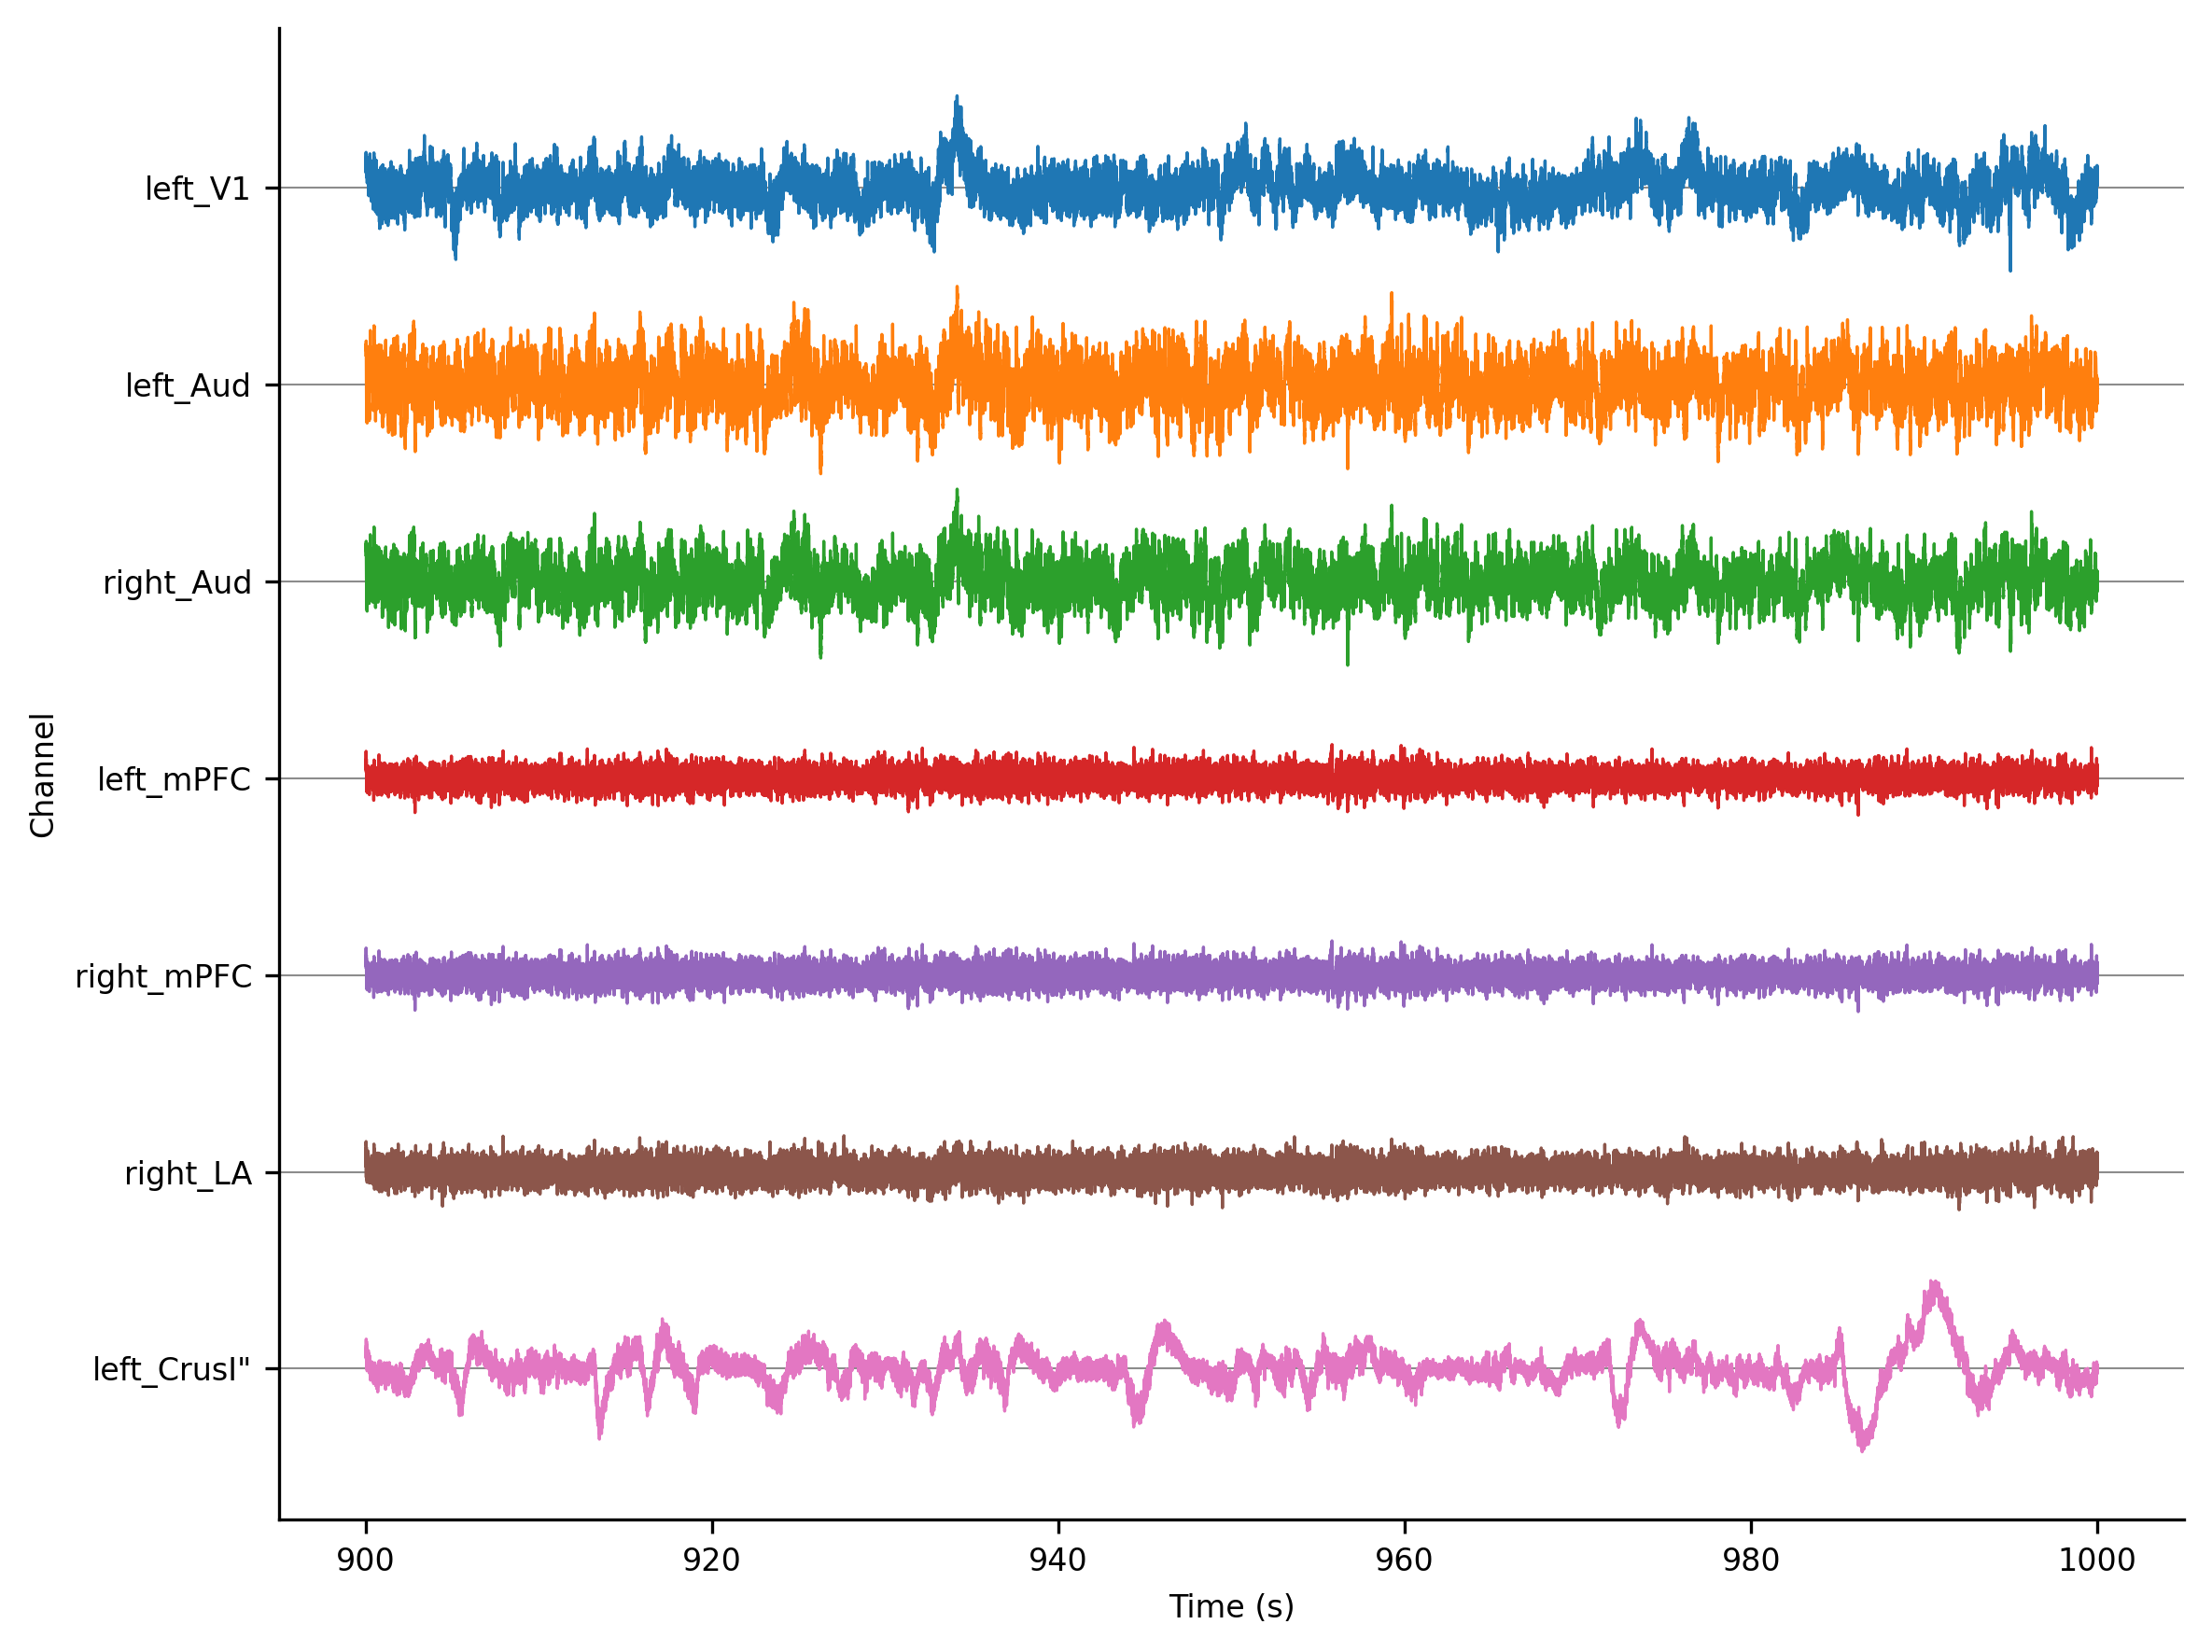

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Define your window (start and end indices)
start_time = 900  # seconds
end_time = 1000.0  # seconds
timestamps = lfp_series.get_timestamps()
start_idx = np.where(timestamps >= start_time)[0][0] if len(np.where(timestamps >= start_time)[0]) > 0 else 0
end_idx = (
    np.where(timestamps <= end_time)[0][-1] if len(np.where(timestamps <= end_time)[0]) > 0 else len(timestamps) - 1
)

# Get the data and timestamps properly
data = np.array(lfp_series.data[start_idx:end_idx])
timestamps = timestamps[start_idx:end_idx]

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Calculate offset for stacking
offset = np.max(np.abs(data)) * 2
y_positions = []

# Plot zero lines for each channel
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.9, linewidth=0.5)
    y_positions.append(y_offset)

# Plot the LFP signals with offset
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.plot(timestamps, data[:, i] + y_offset, linewidth=0.8)

# # Add scale bar
# scale_x = timestamps[0] + (timestamps[-1] - timestamps[0]) * 0.05  # 5% from left
# scale_y = max(y_positions) + offset/2
# ax.plot([scale_x, scale_x], [scale_y, scale_y + 1000], 'k-', linewidth=2)
# ax.text(scale_x + 0.01, scale_y + 500, '1000 µV', rotation=90, va='center')

# Style the plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.tick_params(axis="both", labelsize=8)
ax.set_yticks(y_positions)
yticklabels = lfp_series.electrodes.to_dataframe()["group_name"]
yticklabels = yticklabels.str.replace("_LFP_electrode_group", "")
ax.set_yticklabels(yticklabels, fontsize=8)

plt.xlabel("Time (s)", fontsize=8)
plt.ylabel("LFP Channel", fontsize=8)

plt.tight_layout()
plt.show()

# Access Behavioral Video <a name="access-behavior"></a>

The Behavioral videos are stored as external ImageSeries

In [ ]:
video = nwbfile.acquisition["Video Rat_1021_Baseline_tone_flash_hab"]
video

The video filepath:

In [ ]:
video.external_file[0]

The metadata data of the device used to record the behavioral video:

In [ ]:
video.device

# Accessing Accelerometer Signal <a name="access-accelerometer"></a>

This section demonstrates how to access the accelerometer signals recorded during the experiment. The accelerometer data need to be stored in the `processing` module under `behavior/analog` for compatibility reason with the SensorData table ingested by the Spyglass pipeline.

The accelerometer data can be accessed using `nwbfile.processing["behavior"]["analog"]["analog"]` which returns an TimeSeries object containing the acceleration measurements along different axes (the order need to be explicit in the description of the series).

In [ ]:
accelerometer_series = nwbfile.processing["behavior"]["analog"]["analog"]
accelerometer_series

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Define your window (start and end indices)
start_time = 900  # seconds
end_time = 1000.0  # seconds
timestamps = accelerometer_series.get_timestamps()
start_idx = np.where(timestamps >= start_time)[0][0] if len(np.where(timestamps >= start_time)[0]) > 0 else 0
end_idx = (
    np.where(timestamps <= end_time)[0][-1] if len(np.where(timestamps <= end_time)[0]) > 0 else len(timestamps) - 1
)

# Get the data and timestamps properly
data = np.array(accelerometer_series.data[start_idx:end_idx])
timestamps = timestamps[start_idx:end_idx]

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Calculate offset for stacking
offset = np.max(np.abs(data)) * 2
y_positions = []

# Plot zero lines for each channel
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.9, linewidth=0.5)
    y_positions.append(y_offset)

# Plot the LFP signals with offset
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.plot(timestamps, data[:, i] + y_offset, linewidth=0.8)

# # Add scale bar
# scale_x = timestamps[0] + (timestamps[-1] - timestamps[0]) * 0.05  # 5% from left
# scale_y = max(y_positions) + offset/2
# ax.plot([scale_x, scale_x], [scale_y, scale_y + 1000], 'k-', linewidth=2)
# ax.text(scale_x + 0.01, scale_y + 500, '1000 µV', rotation=90, va='center')

# Style the plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)



ax.tick_params(axis="both", labelsize=8)



ax.set_yticks(y_positions)



yticklabels = accelerometer_series.description.replace("Accelerometer", "").split(" ")



ax.set_yticklabels(yticklabels, fontsize=8)



plt.xlabel("Time (s)", fontsize=8)



plt.ylabel("Channel", fontsize=8)



plt.tight_layout()



plt.show()

# Access Behavioural Paradigm Triggers  <a name="access-ttls"></a>
This section demonstrates how to access the behavioral paradigm triggers (TTL signals) recorded during the experiment. The TTL signals are stored in the `processing` module under `behavior/behavioral_events`. They represent various triggers used in the experimental setup, such as LED stimulus triggers for the conditioning protocol.

The TTL signals can be accessed using `nwbfile.processing["behavior"]["behavioral_events"]["TTL_LED_trigger"]` which returns a TimeSeries object containing the timestamps and values of the LED trigger signals used for the conditioning stimulus.

In [ ]:
LED_trigger = nwbfile.processing["behavior"]["behavioral_events"]["TTL_LED_trigger"]
LED_trigger

In [ ]:
import numpy as np
from matplotlib.gridspec import GridSpec

import matplotlib.pyplot as plt

# Define a common time window to show across all signals
start_time = 900  # seconds
end_time = 1000.0    # seconds

# Create figure with GridSpec for flexible layout
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(3, 1, height_ratios=[1, 2, 2], hspace=0.3)

# Get indices for the time window for each dataset
ttl_timestamps = LED_trigger.get_timestamps()
ttl_start_idx = np.where(ttl_timestamps >= start_time)[0][0] if len(np.where(ttl_timestamps >= start_time)[0]) > 0 else 0
ttl_end_idx = np.where(ttl_timestamps <= end_time)[0][-1] if len(np.where(ttl_timestamps <= end_time)[0]) > 0 else len(ttl_timestamps)-1

eeg_timestamps = eeg_series.get_timestamps()
eeg_start_idx = np.where(eeg_timestamps >= start_time)[0][0] if len(np.where(eeg_timestamps >= start_time)[0]) > 0 else 0
eeg_end_idx = np.where(eeg_timestamps <= end_time)[0][-1] if len(np.where(eeg_timestamps <= end_time)[0]) > 0 else len(eeg_timestamps)-1

lfp_timestamps = lfp_series.get_timestamps()
lfp_start_idx = np.where(lfp_timestamps >= start_time)[0][0] if len(np.where(lfp_timestamps >= start_time)[0]) > 0 else 0 
lfp_end_idx = np.where(lfp_timestamps <= end_time)[0][-1] if len(np.where(lfp_timestamps <= end_time)[0]) > 0 else len(lfp_timestamps)-1

# 1. TTL Trigger Plot
ax1 = fig.add_subplot(gs[0])
ttl_data = np.array(LED_trigger.data[ttl_start_idx:ttl_end_idx])
ttl_times = ttl_timestamps[ttl_start_idx:ttl_end_idx]
ax1.plot(ttl_times, ttl_data, 'k-', linewidth=1.5)
ax1.set_title('TTL LED Trigger', fontsize=12)
ax1.set_ylabel('Value')
ax1.set_xlim(start_time, end_time)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 2. EEG Signals Plot
ax2 = fig.add_subplot(gs[1])
eeg_data = np.array(eeg_series.data[eeg_start_idx:eeg_end_idx])
eeg_times = eeg_timestamps[eeg_start_idx:eeg_end_idx]

# Calculate offset for stacking EEG channels
eeg_offset = np.max(np.abs(eeg_data)) * 2
eeg_y_positions = []

# Plot EEG signals
for i in range(eeg_data.shape[1]):
    y_offset = -i * eeg_offset
    ax2.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.3, linewidth=0.5)
    ax2.plot(eeg_times, eeg_data[:, i] + y_offset, linewidth=0.8)
    eeg_y_positions.append(y_offset)

# Add EEG labels and styling
ax2.set_yticks(eeg_y_positions)
eeg_labels = eeg_series.electrodes.to_dataframe()["group_name"]
eeg_labels = eeg_labels.str.replace("_electrode_group", "")
ax2.set_yticklabels(eeg_labels, fontsize=10)
ax2.set_title('EEG Signals', fontsize=12)
ax2.set_xlim(start_time, end_time)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# 3. LFP Signals Plot
ax3 = fig.add_subplot(gs[2])
lfp_data = np.array(lfp_series.data[lfp_start_idx:lfp_end_idx])
lfp_times = lfp_timestamps[lfp_start_idx:lfp_end_idx]

# Calculate offset for stacking LFP channels
lfp_offset = np.max(np.abs(lfp_data)) * 2
lfp_y_positions = []

# Plot LFP signals
for i in range(lfp_data.shape[1]):
    y_offset = -i * lfp_offset
    ax3.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.3, linewidth=0.5)
    ax3.plot(lfp_times, lfp_data[:, i] + y_offset, linewidth=0.8)
    lfp_y_positions.append(y_offset)

# Add LFP labels and styling
ax3.set_yticks(lfp_y_positions)
lfp_labels = lfp_series.electrodes.to_dataframe()["group_name"]
lfp_labels = lfp_labels.str.replace("_LFP_electrode_group", "")
ax3.set_yticklabels(lfp_labels, fontsize=10)
ax3.set_title('LFP Signals', fontsize=12)
ax3.set_xlabel('Time (s)', fontsize=10)
ax3.set_xlim(start_time, end_time)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Add vertical lines at TTL high-to-low transitions to see stimulus alignment
high_indices = np.where(np.diff(ttl_data) < 0)[0]
for idx in high_indices:
    transition_time = ttl_times[idx]
    ax1.axvline(x=transition_time, color='r', linestyle='--', alpha=0.6, linewidth=1)
    ax2.axvline(x=transition_time, color='r', linestyle='--', alpha=0.6, linewidth=1)
    ax3.axvline(x=transition_time, color='r', linestyle='--', alpha=0.6, linewidth=1)

plt.suptitle(f'Neural Activity and TTL Triggers in Rat {subject_id}, Session: {session_id}', fontsize=14)
# plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()